Welcome to *`DeepDreamArt`* This notebook demonstrates how to generate surreal and artistic images using Google's DeepDream algorithm. The process involves using a pre-trained convolutional neural network to enhance and visualize the features of an input image by maximizing activations from various layers.

### Setup and Imports
Start by importing the necessary libraries and loading the base image. We'll also display the image for visualization.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import time
from tqdm import tqdm


68818/68818 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


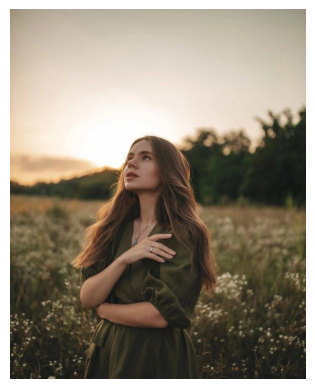

In [2]:
# Load the base image
base_image_path = keras.utils.get_file(
    "img.jpg", origin="https://i.pinimg.com/736x/1d/9f/f2/1d9ff2e93f8c5a439820e89bdb46d606.jpg"
)

# Display the base image
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))
plt.show()

### Load Pre-trained Models
We will use InceptionV3, ResNet50, and VGG16 as the feature extraction networks.

In [3]:
# Load pre-trained models to include preprocess functions
models = {
    "InceptionV3": {
        "model": keras.applications.InceptionV3(weights="imagenet", include_top=False),
        "preprocess": keras.applications.inception_v3.preprocess_input
    },
    "MobileNetV2": {
        "model": keras.applications.MobileNetV2(weights="imagenet", include_top=False),
        "preprocess": keras.applications.mobilenet_v2.preprocess_input
    },
    "ResNet50": {
        "model": keras.applications.ResNet50(weights="imagenet", include_top=False),
        "preprocess": keras.applications.resnet50.preprocess_input
    },
}

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


<ipython-input-3-947563aad8c5>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "model": keras.applications.MobileNetV2(weights="imagenet", include_top=False),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Preprocess Image
The image will be loaded, resized, and preprocessed to fit the input requirements of the pre-trained models.

In [4]:
# 3. Load and Preprocess Image
def preprocess_image(image_path, preprocess_fn):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_fn(img)
    return tf.convert_to_tensor(img)

def deprocess_image(img):
    img = img.numpy()
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img


### Feature Extractor Model for Each Network
Each model will extract features from intermediate layers. We'll use the same approach for all models, such as InceptionV3, ResNet50, and VGG16.

In [5]:
layer_settings = {
    "InceptionV3": {
        "mixed3": 0.8,
        "mixed4": 1.2,
        "mixed5": 1.6,
        "mixed6": 2.0,
        "mixed7": 2.4,
        "mixed8": 2.8,
        "mixed9": 3.2,
        "mixed10": 3.6,
    },
    "ResNet50": {
        "conv3_block4_out": 0.7,
        "conv4_block1_out": 1.0,
        "conv4_block6_out": 1.4,
        "conv5_block1_out": 1.8,
        "conv5_block3_out": 2.2,
        "conv5_block4_out": 2.6,
    },
    "VGG16": {
        "block1_conv2": 0.5,
        "block2_conv2": 0.8,
        "block3_conv3": 1.2,
        "block4_conv3": 1.6,
        "block5_conv2": 2.0,
        "block5_conv3": 2.4,
    },
    "MobileNetV2": {
        "block_6_expand": 0.8,
        "block_11_project": 1.2,
        "block_13_expand": 1.6,
        "block_15_project": 2.0,
        "Conv_1_relu": 2.4,
    },
    "EfficientNetB0": {
        "block2a_activation": 0.8,
        "block3a_expand_activation": 1.2,
        "block4a_expand_activation": 1.6,
        "block5a_expand_activation": 2.0,
        "block6a_expand_activation": 2.4,
        "top_activation": 2.8,
    }
}

In [6]:
def create_feature_extractor(model, layer_settings):
    outputs_dict = {
        layer.name: layer.output
        for layer in model.layers if layer.name in layer_settings
    }
    return keras.Model(inputs=model.input, outputs=outputs_dict)

# feature_extractors = {
#     model_name: create_feature_extractor(model, layer_settings[model_name])
#     for model_name, model in models.items()
# }


### Compute DeepDream Loss
We need to compute the loss to maximize based on the activations of the chosen layers.

In [7]:
def compute_loss(input_image, feature_extractor, layer_settings):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

### Gradient Ascent Step
This step computes the gradient of the loss with respect to the image and updates the image.

In [8]:
@tf.function
def gradient_ascent_step(image, feature_extractor, learning_rate, layer_settings):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, feature_extractor, layer_settings)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

### Gradient Ascent Loop
This loop runs the gradient ascent for a given number of iterations, progressively improving the image.

In [9]:
def gradient_ascent_loop(image, feature_extractor, layer_settings, iterations, learning_rate, max_loss=None):
    for i in tqdm(range(iterations), desc="Processing Image"):
        loss, image = gradient_ascent_step(image, feature_extractor, learning_rate, layer_settings)
        if max_loss is not None and loss > max_loss:
            break
        if i % 5 == 0:
            print(f"... Loss at step {i}: {loss:.2f}")
    return image

### Multi-Layer Dreaming and Comparison
We will run DeepDream for each model and display the results side-by-side.

In [10]:
def apply_deepdream(model_name, image, feature_extractor, layer_settings, learning_rate=0.1, iterations=20, max_loss=15):
    img = tf.identity(image)
    img = gradient_ascent_loop(img, feature_extractor, layer_settings, iterations, learning_rate, max_loss)
    return deprocess_image(img)


# Load and preprocess image separately for each model
deepdream_images = {}
feature_extractors = {}
model_image = {}

for model_name, model_info in models.items():
    print(f"\nApplying DeepDream using {model_name}...")
    model = model_info["model"]
    preprocess_fn = model_info["preprocess"]

    # Preprocess image with the correct function
    model_img = preprocess_image(base_image_path, preprocess_fn)
    model_image[model_name] = model_img

    # Create feature extractor for the current model
    feature_extractor = create_feature_extractor(model, layer_settings[model_name])
    feature_extractors[model_name] = feature_extractor

    # Run DeepDream and store output
    deepdream_images[model_name] = apply_deepdream(
        model_name, model_img, feature_extractor, layer_settings[model_name]
    )

# # Run DeepDream on all three models and visualize
# deepdream_images = {}
# for model_name in models:
#     print(f"\nApplying DeepDream using {model_name}...")
#     deepdream_images[model_name] = apply_deepdream(
#         model_name, original_img, feature_extractors[model_name], layer_settings[model_name]
#     )


Applying DeepDream using InceptionV3...


Processing Image:  15%|█▌        | 3/20 [00:08<00:39,  2.35s/it]

... Loss at step 0: 2.60


Processing Image:  35%|███▌      | 7/20 [00:09<00:09,  1.40it/s]

... Loss at step 5: 3.48


Processing Image:  65%|██████▌   | 13/20 [00:09<00:01,  4.00it/s]

... Loss at step 10: 4.29


Processing Image:  85%|████████▌ | 17/20 [00:10<00:00,  6.36it/s]

... Loss at step 15: 5.08


Processing Image: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]



Applying DeepDream using MobileNetV2...


Processing Image:  25%|██▌       | 5/20 [00:02<00:06,  2.34it/s]

... Loss at step 0: 12.34
... Loss at step 5: 12.92


Processing Image:  80%|████████  | 16/20 [00:03<00:00, 10.24it/s]

... Loss at step 10: 13.52
... Loss at step 15: 14.13


Processing Image: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]



Applying DeepDream using ResNet50...


Processing Image:  15%|█▌        | 3/20 [00:05<00:23,  1.40s/it]

... Loss at step 0: 8.33


Processing Image:  35%|███▌      | 7/20 [00:05<00:05,  2.17it/s]

... Loss at step 5: 8.34


Processing Image:  65%|██████▌   | 13/20 [00:06<00:01,  5.17it/s]

... Loss at step 10: 8.36


Processing Image:  85%|████████▌ | 17/20 [00:06<00:00,  7.13it/s]

... Loss at step 15: 8.37


Processing Image: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


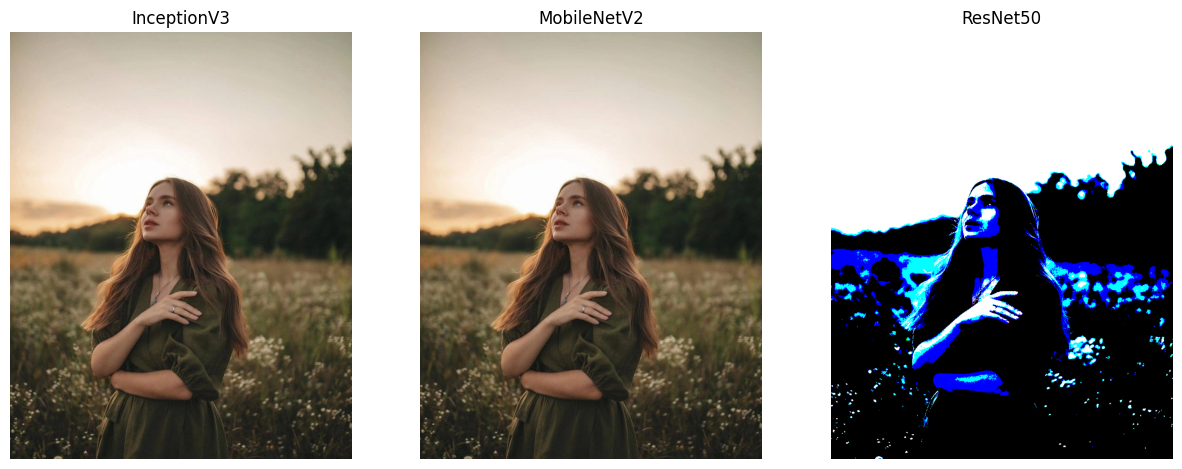

In [11]:
# Plot the generated DeepDream images
fig, axes = plt.subplots(1, len(models), figsize=(15, 10))
for i, (model_name, img) in enumerate(deepdream_images.items()):
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(model_name)
plt.show()

## Multi-Octave DeepDream Loop for Final Result

In [12]:
original_img = model_image["InceptionV3"]

base_shape = tf.shape(original_img)[1:3].numpy()
successive_shapes = [base_shape]
for i in range(3):
    shape = tuple([int(dim / (1.4 ** i)) for dim in base_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]  # Smallest to original size

In [13]:
# Use InceptionV3 for final multiscale dreaming
feature_extractor = feature_extractors["InceptionV3"]
img = tf.identity(original_img)
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

iterations = 20
max_loss = 15.0

for i, shape in enumerate(successive_shapes):
    print(f"\n🔁 Processing octave {i+1}/{len(successive_shapes)} with shape: {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, feature_extractor, layer_settings["InceptionV3"], iterations, 20.0, max_loss)

    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail

    shrunk_original_img = tf.image.resize(original_img, shape)


🔁 Processing octave 1/4 with shape: (459, 367)


Processing Image:  25%|██▌       | 5/20 [00:05<00:11,  1.27it/s]

... Loss at step 0: 4.82
... Loss at step 5: 10.00


Processing Image:  45%|████▌     | 9/20 [00:05<00:06,  1.67it/s]



🔁 Processing octave 2/4 with shape: (642, 514)


Processing Image:  20%|██        | 4/20 [00:07<00:21,  1.36s/it]

... Loss at step 0: 3.46


Processing Image:  50%|█████     | 10/20 [00:07<00:03,  2.57it/s]

... Loss at step 5: 8.44


Processing Image:  55%|█████▌    | 11/20 [00:07<00:06,  1.47it/s]


... Loss at step 10: 14.45

🔁 Processing octave 3/4 with shape: (900, 720)


Processing Image:  10%|█         | 2/20 [00:03<00:28,  1.60s/it]

... Loss at step 0: 3.45


Processing Image:  40%|████      | 8/20 [00:04<00:03,  3.89it/s]

... Loss at step 5: 9.91


Processing Image:  60%|██████    | 12/20 [00:04<00:03,  2.55it/s]


... Loss at step 10: 13.51

🔁 Processing octave 4/4 with shape: [900 720]


Processing Image:   5%|▌         | 1/20 [00:00<00:02,  6.48it/s]

... Loss at step 0: 14.84


## Save and visualize final dreamy image

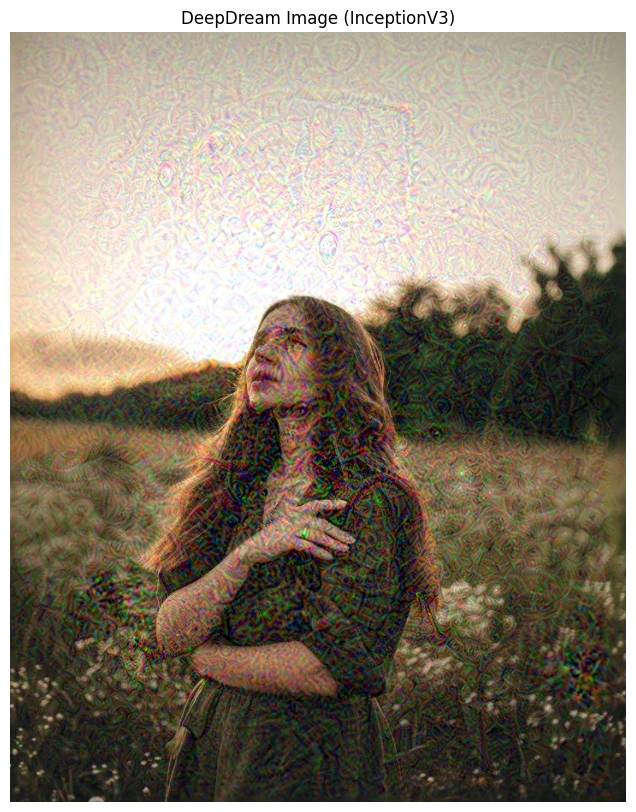

In [14]:
final_img = deprocess_image(img)
keras.utils.save_img("dream.png", final_img)
plt.figure(figsize=(10, 10))
plt.imshow(final_img)
plt.axis("off")
plt.title("DeepDream Image (InceptionV3)")
plt.show()